# DeepSynergy on Logical Gates

We replicate the classic **AND gate** experiment and use it to validate three key quantities:

1. $H(Y \mid X_1, X_2)$ — estimated via a decoder $q(y \mid x_1, x_2)$  
2. $H(X_i \mid Y)$ for $i=1,2$ — estimated via decoders $q(x_i \mid y)$  
3. $\max_Z H(Y \mid Z)$ — estimated using the adversarial **DeepSynergy** model, under the Blackwell constraint

The final synergy is computed as:

$$
S = \max_Z H(Y \mid Z) \;-\; H(Y \mid X_1, X_2)
$$

All quantities are reported in **bits**.


In [2]:
# ─── Core Libraries ──────────────────────────────────────────────────
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ─── DeepSynergy Package ─────────────────────────────────────────────
from deepsynergy import (
    DeepSynergy,
    decoders,
    encoders,
)
from deepsynergy.utils_training import (
    train_decoder,
    train_deepsynergy_model,
    relax_deepsynergy_model,
    ParameterScheduler,
)

# ─── Logic Gate Dataset ──────────────────────────────────────────────
from deepsynergy.utils_data import gate_AND  # (also: gate_XOR, gate_UNQ, gate_RDN)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Gate Truth Table

We start by loading the dataset for the AND logic gate.  
It consists of 4 binary input-output pairs.

You can swap `gate_AND` with `gate_XOR`, `gate_UNQ`, or `gate_RDN` to test other gates.

In [3]:
# Load the full truth table of the AND gate
X, Y = gate_AND()  # Shapes: (4, 2) and (4, 1)

print("Truth table (X1, X2, Y):")
print(torch.cat((X, Y), dim=1))

Truth table (X1, X2, Y):
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 1., 1.]])


## 1 · Decoder for $H(Y \mid X_1, X_2)$

For a deterministic gate like AND, the conditional entropy  
$H(Y \mid X_1, X_2)$ should be **exactly zero**.

We train a binary decoder $q(y \mid x_1, x_2)$ to confirm this behavior.

/home/nuzzi/Projects/DeepSynergy/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
100%|██████████| 2000/2000 [00:17<00:00, 112.17it/s, loss=[6.993799e-05]] 


Estimated H(Y | X₁, X₂): 0.000 bits  (expected: 0 bits)


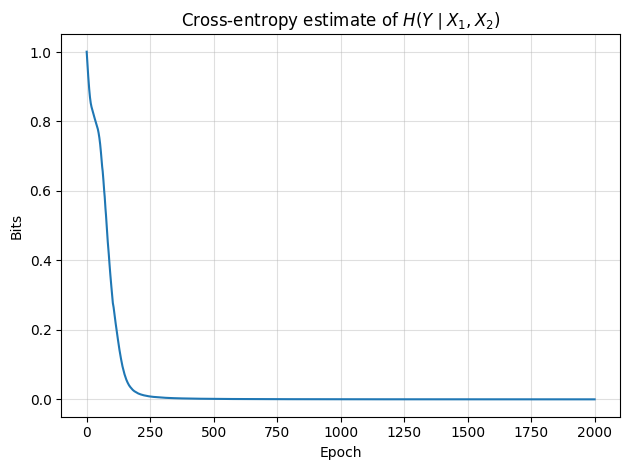

In [4]:
# ─── Training setup ──────────────────────────────────────────────────
batch_size = 4     # use full truth table in each batch
epochs     = 2000  # number of training iterations

dataloader = DataLoader(TensorDataset(X, Y), batch_size=batch_size)

# ─── Define binary decoder for q(y | x₁, x₂) ─────────────────────────
decoder_y_x = decoders.BinaryDecoder(
    nn.Sequential(
        nn.Linear(2, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 1),
    )
).to(device)

optim = torch.optim.Adam(decoder_y_x.parameters(), lr=1e-2)

# ─── Train decoder and evaluate entropy estimate ─────────────────────
results_y_x = train_decoder(
    model         = decoder_y_x,
    dataloader    = dataloader,
    optimizer     = optim,
    show_progress = True,
    device        = device,
    epochs        = epochs,
)

H_y_x = results_y_x["loss"][0]
print(f"Estimated H(Y | X₁, X₂): {H_y_x:.3f} bits  (expected: 0 bits)")

# ─── Plot training curve ─────────────────────────────────────────────
plt.figure()
plt.plot(results_y_x["loss_history"], color="tab:blue")
plt.title("Cross-entropy estimate of $H(Y \\mid X_1, X_2)$")
plt.xlabel("Epoch")
plt.ylabel("Bits")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

## 2 · Decoder for $H(X_i \mid Y)$  (Blackwell lower bound)

For the AND gate, both $X_1$ and $X_2$ contain incomplete information about $Y$.

The analytic value of $H(X_i \mid Y)$ is:

$$
H(X_i \mid Y) = \tfrac{3}{4} \log_2 3 - \tfrac{1}{2} \approx 0.688 \text{ bits}.
$$

We estimate this using a decoder $q(x_i \mid y)$ that predicts both source bits from the target.


  0%|          | 0/2000 [00:00<?, ?it/s, loss=[1.0091373  0.98805207]]

100%|██████████| 2000/2000 [00:17<00:00, 117.30it/s, loss=[0.68885124 0.68885565]]


Estimated H(X₁ | Y): 0.689 bits  (theory: 0.689)
Estimated H(X₂ | Y): 0.689 bits  (theory: 0.689)


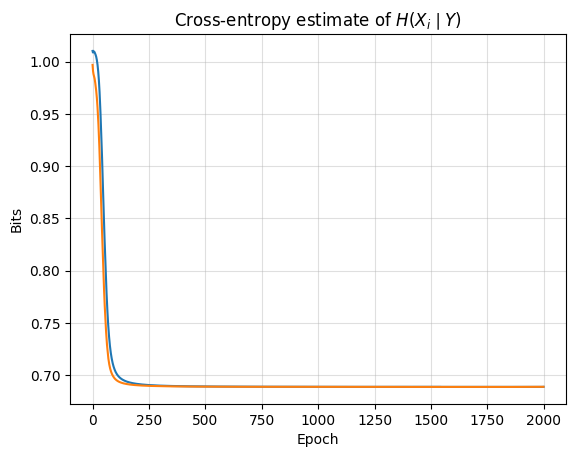

In [5]:
# ─── Setup ───────────────────────────────────────────────────────────
batch_size    = 4
epochs        = 2000
H_theory_Xi   = 0.75 * np.log2(3) - 0.5  # ~0.688 bits

# Use Y as input, X = (X1, X2) as output
loader = DataLoader(TensorDataset(Y, X), batch_size=batch_size)

# Binary decoder: predicts both x₁ and x₂ from Y
decoder_x_y = decoders.BinaryDecoder(
    nn.Sequential(
        nn.Linear(1, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 2),  # output logits for both X₁ and X₂
    )
).to(device)

optim = torch.optim.Adam(decoder_x_y.parameters(), lr=1e-2)

results_x_y = train_decoder(
    model         = decoder_x_y,
    dataloader    = loader,
    optimizer     = optim,
    show_progress = True,
    device        = device,
    epochs        = epochs,
)

# Plot training curve
plt.figure()
plt.plot(results_x_y["loss_history"])
plt.title("Cross-entropy estimate of $H(X_i \\mid Y)$")
plt.xlabel("Epoch")
plt.ylabel("Bits")
plt.grid(alpha=0.4)

# Final entropy estimate (per source bit)
H_xi_y = results_x_y["loss"]  # shape: (2,)
print(f"Estimated H(X₁ | Y): {H_xi_y[0]:.3f} bits  (theory: {H_theory_Xi:.3f})")
print(f"Estimated H(X₂ | Y): {H_xi_y[1]:.3f} bits  (theory: {H_theory_Xi:.3f})")


## 3 · DeepSynergy DataLoader Setup

We duplicate each of the 4 truth-table samples 128 times.  

This gives larger batches for GPU efficiency without introducing statistical noise.  
Each duplicate still undergoes independent latent sampling, enabling better estimation of the expectations in the loss.

This trick effectively boosts the Monte Carlo estimate used to compute $\max_Z H(Y \mid Z)$.


In [6]:
# Repeat each of the 4 (X, Y) rows 128× to increase batch size
X_rep = X.repeat_interleave(128, dim=0)
Y_rep = Y.repeat_interleave(128, dim=0)

# All samples fit in a single batch
loader_ds = DataLoader(TensorDataset(X_rep, Y_rep), batch_size=512)

In [7]:
# ─── DeepSynergy model setup ─────────────────────────────────────────

latent_dim = 2  # dimensionality of latent Z

# Encoder: maps Y → Z using a Gaussian latent layer
encoder = encoders.GaussianEncoder(
    nn.Sequential(
        nn.Linear(1, 8), nn.ReLU(),
        nn.Linear(8, 16), nn.ReLU(),
    ),
    latent_dim = latent_dim,
    layers_post = nn.Sequential(
        nn.Linear(latent_dim, 8), nn.ReLU(),
        nn.Linear(8, latent_dim),
    )
)

# Discriminator head: q(Y | Z)
disc_y = decoders.BinaryDecoder(
    nn.Sequential(
        nn.Linear(latent_dim, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 1),
    )
)

# Constraint head: q(X | Z), outputs logits for X₁ and X₂
gen_x = decoders.BinaryDecoder(
    nn.Sequential(
        nn.Linear(latent_dim, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 2),
    )
)

# Create DeepSynergy model
model = DeepSynergy(
    q_z_given_y = encoder,
    q_y_given_z = disc_y,
    q_x_given_z = gen_x,
    num_z_samples = 200,
    optimizer     = (torch.optim.Adam, torch.optim.Adam),
    lr            = (1e-2, 1e-2),
).to(device)


100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s, beta=30, loss_y avg=[0.51414716], loss_x avg=[0.6985353 0.706061 ]]   


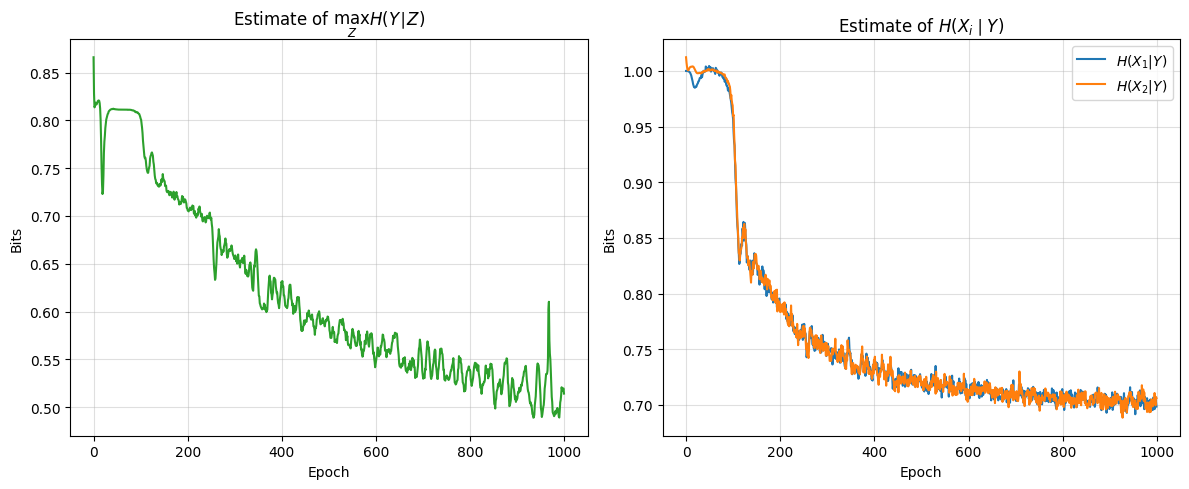

In [8]:
# ─── Train DeepSynergy model ─────────────────────────────────────────

# Ramp up the beta parameter to gradually enforce the Blackwell constraint
beta_scheduler = ParameterScheduler(
    value_min  = 1,
    value_max  = 30,
    epochs_num = 1000,
    method     = "linear",
)

train_results = train_deepsynergy_model(
    model       = model,
    dataloader  = loader_ds,
    beta        = beta_scheduler,
    alpha       = 5,
    n_critic    = 5,
    epochs      = 1000,
    device      = device,
)

# ─── Plot training results ───────────────────────────────────────────

plt.figure(figsize=(12, 5))

# Plot adversarial H(Y | Z)
plt.subplot(1, 2, 1)
plt.plot(train_results["loss_y_history"], color="tab:green")
plt.title("Estimate of $\\max_Z H(Y \\mid Z)$")
plt.xlabel("Epoch")
plt.ylabel("Bits")
plt.grid(alpha=0.4)

# Plot constraint losses H(X₁ | Y) and H(X₂ | Y)
plt.subplot(1, 2, 2)
plt.plot(train_results["loss_x_history"][:, 0], label="$H(X_1 | Y)$")
plt.plot(train_results["loss_x_history"][:, 1], label="$H(X_2 | Y)$")
plt.title("Estimate of $H(X_i \\mid Y)$")
plt.xlabel("Epoch")
plt.ylabel("Bits")
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()


## 4 · Relaxation phase — Final synergy estimate

After adversarial training, we freeze the generator and continue training only the discriminator  
for a few more epochs. This helps ensure that $q(Y \mid Z)$ is fully optimized given the current encoder distribution.

We then estimate synergy as:

$$
\text{Synergy} = \max_Z H(Y \mid Z) - H(Y \mid X_1, X_2).
$$


100%|██████████| 500/500 [00:08<00:00, 57.26it/s, loss_y avg=[0.51089853]]


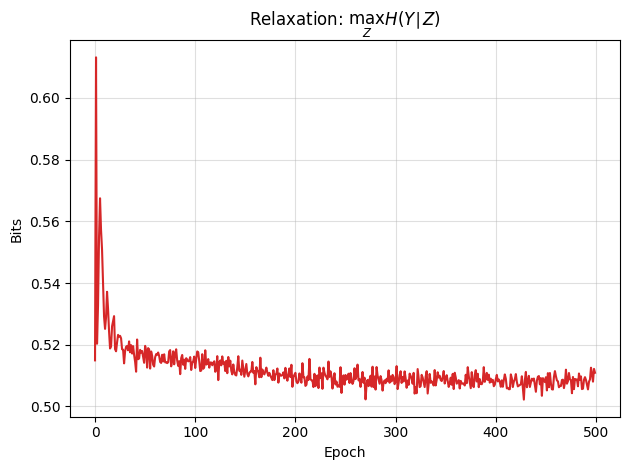

In [9]:
# ─── Final relaxation phase ─────────────────────────────────────────

# Re-initialize the optimizers before discriminator-only fine-tuning
model.reset_optimizers(optimizer="Adam", lr=1e-2)

# Fine-tune discriminator while keeping the generator fixed
relax_results = relax_deepsynergy_model(
    model      = model,
    dataloader = loader_ds,
    epochs     = 500,
    device     = device,
)

# Plot the relaxed estimate of max H(Y|Z)
plt.figure()
plt.plot(relax_results["loss_y_history"], color="tab:red")
plt.title("Relaxation: $\\max_Z H(Y \\mid Z)$")
plt.xlabel("Epoch")
plt.ylabel("Bits")
plt.grid(alpha=0.4)
plt.tight_layout()


In [10]:
# ─── Final synergy estimate ─────────────────────────────────────────

H_y_z   = relax_results["loss_y"][0]       # max_Z H(Y|Z)
H_y_x12 = results_y_x["loss"][0]           # H(Y|X₁,X₂), should be ~0 for deterministic gate

synergy = H_y_z - H_y_x12

print(f"Synergy (AND gate): {synergy:.4f} bits")


Synergy (AND gate): 0.5108 bits
